# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import os 
from glob import glob 

from PIL import Image, ImageOps
import albumentations as A
import cv2

from tqdm import tqdm 

In [7]:
df = pd.read_csv('/data/ephemeral/home/data/train.csv')

In [8]:
ids = []
targets = []
data_path = '/data/ephemeral/home/data/train/'
for index, ID, target in tqdm(df.itertuples(), desc='Image rotation', mininterval=0.1):
    image_path = os.path.join(data_path, ID)

    # 90도 회전 
    id_90 = 'r90_'+ ID
    ids.append(id_90)
    targets.append(target)
    rotate90_image = np.array(ImageOps.exif_transpose(Image.open(image_path).rotate(90, expand=True)))
    Image.fromarray(rotate90_image).save(os.path.join(data_path, id_90))
    
    # 180도 회전 
    id_180 = 'r180_'+ ID
    ids.append(id_180)
    targets.append(target)
    rotate180_image = np.array(ImageOps.exif_transpose(Image.open(image_path).rotate(180, expand=True)))
    Image.fromarray(rotate180_image).save(os.path.join(data_path, id_180))

    # 270도 회전 
    id_270 = 'r270_'+ ID
    ids.append(id_270)
    targets.append(target)
    rotate270_image = np.array(ImageOps.exif_transpose(Image.open(image_path).rotate(270, expand=True)))
    Image.fromarray(rotate270_image).save(os.path.join(data_path, id_270))

rotate_data = {
    'ID' : ids,
    'target' : targets
}
rotate_df = pd.DataFrame(rotate_data)    
df = pd.concat([df, rotate_df])

Image rotation: 1570it [00:12, 129.90it/s]


In [9]:
H_flip = A.HorizontalFlip(always_apply=True, p=1)
V_flip = A.VerticalFlip(always_apply=True, p=1)

In [10]:
ids = []
targets = []
data_path = '/data/ephemeral/home/data/train'
for index, ID, target in tqdm(df.itertuples(), desc='Image flip', mininterval=0.1):
    image_path = os.path.join(data_path, ID)
    image = np.array(Image.open(image_path))

    if ID.startswith('r90') or ID.startswith('r270'):
        # V flip
        id_vflip = 'Vflip_'+ ID
        ids.append(id_vflip)
        targets.append(target)
        vflip_image = V_flip(image=image)['image']
        Image.fromarray(vflip_image).save(os.path.join(data_path, id_vflip))
    else:
        # H flip
        id_hflip = 'Hflip_'+ ID
        ids.append(id_hflip)
        targets.append(target)
        hflip_image = H_flip(image=image)['image']
        Image.fromarray(hflip_image).save(os.path.join(data_path, id_hflip))
    
flip_data = {
    'ID' : ids,
    'target' : targets
}
flip_df = pd.DataFrame(flip_data)    
df = pd.concat([df, flip_df])

Image flip: 6280it [00:12, 488.93it/s]


In [11]:
transforms = A.Compose([
    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=True, p=1),
        A.ElasticTransform(always_apply=True, p=1, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=1, value=(0, 0, 0), mask_value=None, approximate=False),
        A.OpticalDistortion(always_apply=True, p=1, distort_limit=(-0.3, -0.1)),
        A.OpticalDistortion(always_apply=True, p=1, distort_limit=(0.1, 0.3)),
    ], p=0.85),
    A.SomeOf([
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=20, p=1),
        A.MultiplicativeNoise(p=1, multiplier=(1, 1.5), per_channel=True),
        A.Equalize(p=1, mode='cv', by_channels=True),
    ], n=2, p=0.85),
    A.OneOf([
        A.Rotate(limit=(10, 30), border_mode=cv2.BORDER_CONSTANT, p=1),
        A.Rotate(limit=(150, 170), border_mode=cv2.BORDER_CONSTANT, p=1),
        A.Rotate(limit=(190, 210), border_mode=cv2.BORDER_CONSTANT, p=1),
        A.Rotate(limit=(330, 350), border_mode=cv2.BORDER_CONSTANT, p=1),
    ], p=1),
    A.CoarseDropout(p=0.5, max_holes=40, max_height=15, max_width=15, min_holes=8, min_height=8, min_width=8),
    A.Equalize(p=0.5, mode='cv', by_channels=True),
    A.OneOf([
        A.Blur(blur_limit=(3, 4), p=1),
        A.MotionBlur(blur_limit=(3, 5), p=1),
        A.Downscale(scale_min=0.455, scale_max=0.5, interpolation=2, p=1),
    ], p=0.5),
    A.GaussNoise(var_limit=(100, 800), per_channel=True, p=0.5),
])

In [12]:
ids = []
targets = []
data_path = '/data/ephemeral/home/data/train'
for index, ID, target in tqdm(df.itertuples(), desc='Image augmentation', mininterval=0.1):
    image_path = os.path.join(data_path, ID)
    image = np.array(Image.open(image_path))
    if target == 13:
        n = 13
    elif target == 14:
        n = 20
    elif target == 1:
        n = 21
    else:
        n = 10
    for i in range(n):
        transformed_image = transforms(image=image)['image']
        image_ID = f'tf{i}_' + ID 
        ids.append(image_ID)
        targets.append(target)
        Image.fromarray(transformed_image).save(os.path.join(data_path, image_ID))
    
aug_data = {
    'ID' : ids,
    'target' : targets
}
aug_df = pd.DataFrame(aug_data)    
df = pd.concat([df, aug_df])

Image augmentation: 12560it [1:51:24,  1.88it/s]


In [15]:
df.to_csv('/data/ephemeral/home/data/train.csv', index=False)

In [3]:
%pip install tensorflow

  Obtaining dependency information for tensorboard<2.16,>=2.15 from https://files.pythonhosted.org/packages/37/12/f6e9b9dcc310263cbd3948274e286538bd6800fd0c268850788f14a0c6d0/tensorboard-2.15.2-py3-none-any.whl.metadata
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Obtaining dependency information for keras<2.16,>=2.15.0 from https://files.pythonhosted.org/packages/fc/a7/0d4490de967a67f68a538cc9cdb259bff971c4b5787f7765dc7c8f118f71/keras-2.15.0-py3-none-any.whl.metadata
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Obtaining dependency information for google-auth-oauthlib<2,>=0.5 from https://files.pythonhosted.org/packages/71/bf/9e125754d1adb3bc4bd206c4e5df756513b1d23675ac06caa471278d1f3f/google_auth_oauthlib-1.2.0-py2.py3-none-any.whl.metadata
  Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Obtaining dependency information for tensorboard-data-server<0.8.0,>=0.7.0 from https://files.pythonhosted.org/package

In [2]:
%pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c1/f2/325897d6c498278b0f8b460d44b516f5db865ddb4ba9018e9fe58a3e4633/matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/58/56/e2c43dcfa1f9c7db4d5e3d6f5134b24ed953f4e2133a4b12f0062148db58/contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/a6/ba/5eac3e9c9bbc2dea3606e46de08bcef0908d74e7ccf89a71701b95a16747/fonttools-4.49.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
%pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e3/ba/aa8a76eff5c20761b0361a5b4c9fccb8742c29a82adba7a8ad8ae819984e/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/fa/39/5aae571e5a5f4de9c3445dae08a530498e5c53b0e74410eeeb0991c79047/gast-0.5.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Obt

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import glob

2024-02-18 06:00:07.919812: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 06:00:07.962158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 06:00:07.962193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 06:00:07.962840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 06:00:07.967262: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 06:00:07.967726: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
path_working = '/data/ephemeral/home/data/test'

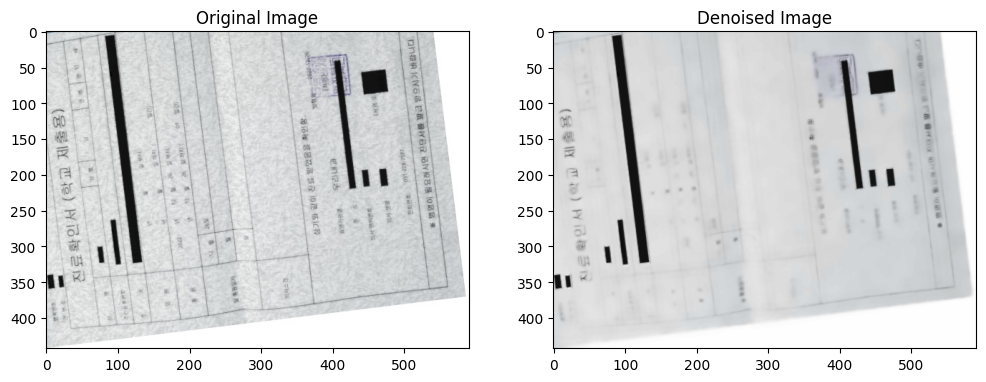

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

orig_img = cv2.imread('/data/ephemeral/home/data/test/0b0e7e754b5a103c.jpg')[...,::-1]

dst = cv2.fastNlMeansDenoisingColored(orig_img,None,10,10,7,21)

plt.figure(figsize=(12,8))
plt.subplot(121), plt.imshow(orig_img),plt.title("Original Image")
plt.subplot(122), plt.imshow(dst), plt.title("Denoised Image")
plt.show()

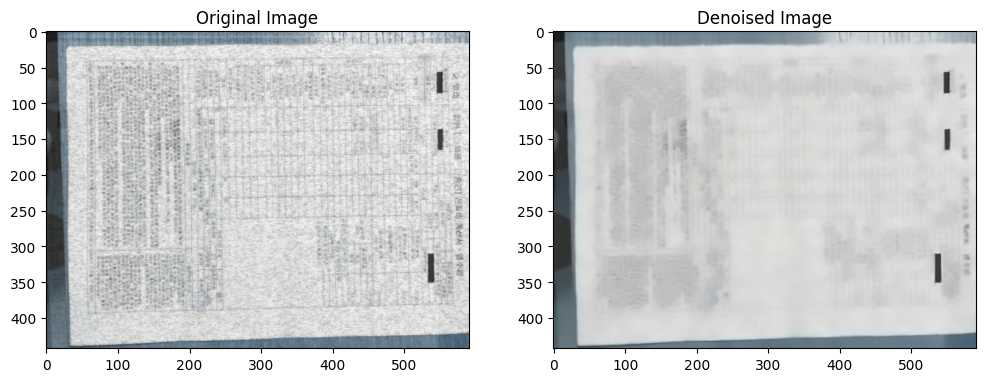

In [7]:
orig_img = cv2.imread('/data/ephemeral/home/data/test/ffb4b6f619fb60ea.jpg')[...,::-1]

dst = cv2.fastNlMeansDenoisingColored(orig_img,None,10,10,7,21)

plt.figure(figsize=(12,8))
plt.subplot(121), plt.imshow(orig_img),plt.title("Original Image")
plt.subplot(122), plt.imshow(dst), plt.title("Denoised Image")
plt.show()

DDNM

In [18]:
!git clone https://github.com/wyhuai/DDNM.git

Cloning into 'DDNM'...
remote: Enumerating objects: 604, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 604 (delta 155), reused 68 (delta 68), pack-reused 423
Receiving objects: 100% (604/604), 14.29 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [20]:
mkdir /content/DDNM/hq_demo/data/pretrained

mkdir: cannot create directory ‘/content/DDNM/hq_demo/data/pretrained’: No such file or directory
